In [1]:
import os
import time                                                           #hemasundar784@mail.com
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers

In [2]:

# Set random seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

# Data directory
data_dir =r"/content/drive/MyDrive/Colab Notebooks/Lung and Colon cancer /lc25k/lung_colon_image_set"

# Filepaths and labels
filepaths = []
labels = []
folds = os.listdir(data_dir)

# Limit for taking images from each category
image_limit = 2500

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)[:image_limit]  # Limiting images
        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)
            if f == "colon_aca":
                labels.append("Colon Adenocarcinoma")
            elif f == "colon_n":
                labels.append("Colon Benign Tissue")
            elif f == "lung_aca":
                labels.append("Lung Adenocarcinoma")
            elif f == "lung_n":
                labels.append("Lung Benign Tissue")
            elif f == "lung_scc":
                labels.append("Lung Squamous Cell Carcinoma")


In [3]:
# Create DataFrame
Fseries = pd.Series(filepaths, name="file_paths")
Lseries = pd.Series(labels, name="Labels")
df = pd.concat([Fseries, Lseries], axis=1)
'''
# Split data
strat = df["Labels"]
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = dummy_df["Labels"]
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)'''


'\n# Split data\nstrat = df["Labels"]\ntrain_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)\nstrat = dummy_df["Labels"]\nvalid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)'

In [26]:
'''
# Save the split dataframes to pickle files
train_df.to_pickle('/content/drive/MyDrive/fullcode/train_df.pkl')
valid_df.to_pickle('/content/drive/MyDrive/fullcode/valid_df.pkl')
test_df.to_pickle('/content/drive/MyDrive/fullcode/test_df.pkl')
print("perfect")                                                         '''

perfect


In [4]:
import pandas as pd

# Load the split dataframes from pickle files
train_df = pd.read_pickle('/content/drive/MyDrive/fullcode/train_df.pkl')
valid_df = pd.read_pickle('/content/drive/MyDrive/fullcode/valid_df.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/fullcode/test_df.pkl')


In [5]:
# Define a preprocessing function for median filtering
def preprocess_image(image):
    import cv2
    import numpy as np
    return cv2.medianBlur(np.array(image), 3)

# Image generator parameters
batch_size = 64
img_size = (224, 224)

# Image preprocessing with median filtering
tre_gen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

# Image generators
train_gen = tre_gen.flow_from_dataframe(
    train_df,
    x_col='file_paths',
    y_col='Labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)
valid_gen = tre_gen.flow_from_dataframe(
    valid_df,
    x_col='file_paths',
    y_col='Labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)
test_gen = tre_gen.flow_from_dataframe(
    test_df,
    x_col='file_paths',
    y_col='Labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


Found 8489 validated image filenames belonging to 5 classes.
Found 1061 validated image filenames belonging to 5 classes.
Found 1062 validated image filenames belonging to 5 classes.


In [13]:
'''

# Feature extraction with MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

# Freeze MobileNetV2 layers
base_model.trainable = False        '''

In [42]:
#base_model.save("/content/drive/MyDrive/fullcode/mobilenet_basemodel")

In [7]:
import tensorflow as tf

# Load the saved MobileNetV2 base model
loaded_base_model = tf.keras.models.load_model("/content/drive/MyDrive/fullcode/mobilenet_basemodel")

# Ensure that the loaded base model is not trainable
loaded_base_model.trainable = False
'''
# Check the summary of the loaded base model
loaded_base_model.summary()'''


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [9]:
g_dict =test_gen.class_indices
classes=list(g_dict.keys())
# CNN Model
model = Sequential([
    loaded_base_model,
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

'''
# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    verbose=1
)

# Evaluate model
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Test Accuracy: {accuracy*100:.2f}%')  '''

"\n# Compile model\nmodel.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])\n\n# Train model\nhistory = model.fit(\n    train_gen,\n    epochs=10,\n    validation_data=valid_gen,\n    verbose=1\n)\n\n# Evaluate model\nloss, accuracy = model.evaluate(test_gen, verbose=0)\nprint(f'Test Accuracy: {accuracy*100:.2f}%')  "

In [19]:
'''
model.save("/content/drive/MyDrive/fullcode/fullseq.keras")
model.save("/content/drive/MyDrive/fullcode/fullseq.h5")
print("perfect")'''

perfect


In [31]:
'''
# Continue training for additional 20 epochs
history = model.fit(
    train_gen,
    epochs=15,  # Increase the total number of epochs to 20
    initial_epoch=10,  # Start from the 11th epoch
    validation_data=valid_gen,
    verbose=1
)

# Evaluate model after completing 30 epochs
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Test Accuracy after 30 epochs: {accuracy*100:.2f}%')       '''


Epoch 11/15
133/133 [==============================] - 470s 4s/step - loss: 0.1882 - accuracy: 0.9264 - val_loss: 0.1996 - val_accuracy: 0.9208
Epoch 12/15
133/133 [==============================] - 455s 3s/step - loss: 0.1773 - accuracy: 0.9324 - val_loss: 0.1757 - val_accuracy: 0.9274
Epoch 13/15
133/133 [==============================] - 502s 4s/step - loss: 0.1738 - accuracy: 0.9318 - val_loss: 0.1660 - val_accuracy: 0.9331
Epoch 14/15
133/133 [==============================] - 478s 4s/step - loss: 0.1680 - accuracy: 0.9363 - val_loss: 0.1756 - val_accuracy: 0.9331
Epoch 15/15
133/133 [==============================] - 486s 4s/step - loss: 0.1693 - accuracy: 0.9354 - val_loss: 0.1762 - val_accuracy: 0.9274
Test Accuracy after 30 epochs: 91.71%


In [32]:
'''
model.save("/content/drive/MyDrive/fullcode/ffullseq.keras")
model.save("/content/drive/MyDrive/fullcode/ffullseq.h5")
print("perfect")'''

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


perfect


In [48]:
'''
# Continue training for additional 20 epochs
history = model.fit(
    train_gen,                                                            #3rd time
    epochs=18,  # Increase the total number of epochs to 20
    initial_epoch=15,  # Start from the 16th epoch
    validation_data=valid_gen,
    verbose=1
)

# Evaluate model after completing 30 epochs
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Test Accuracy after 30 epochs: {accuracy*100:.2f}%')   '''

Epoch 16/18
133/133 [==============================] - 558s 4s/step - loss: 0.1602 - accuracy: 0.9405 - val_loss: 0.1734 - val_accuracy: 0.9293
Epoch 17/18
133/133 [==============================] - 512s 4s/step - loss: 0.1587 - accuracy: 0.9403 - val_loss: 0.1734 - val_accuracy: 0.9274
Epoch 18/18
133/133 [==============================] - 511s 4s/step - loss: 0.1587 - accuracy: 0.9392 - val_loss: 0.1728 - val_accuracy: 0.9265
Test Accuracy after 30 epochs: 91.81%


In [49]:
'''
model.save("/content/drive/MyDrive/fullcode/fffullseq.keras")
model.save("/content/drive/MyDrive/fullcode/fffullseq.h5")
print("perfect") '''

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


perfect


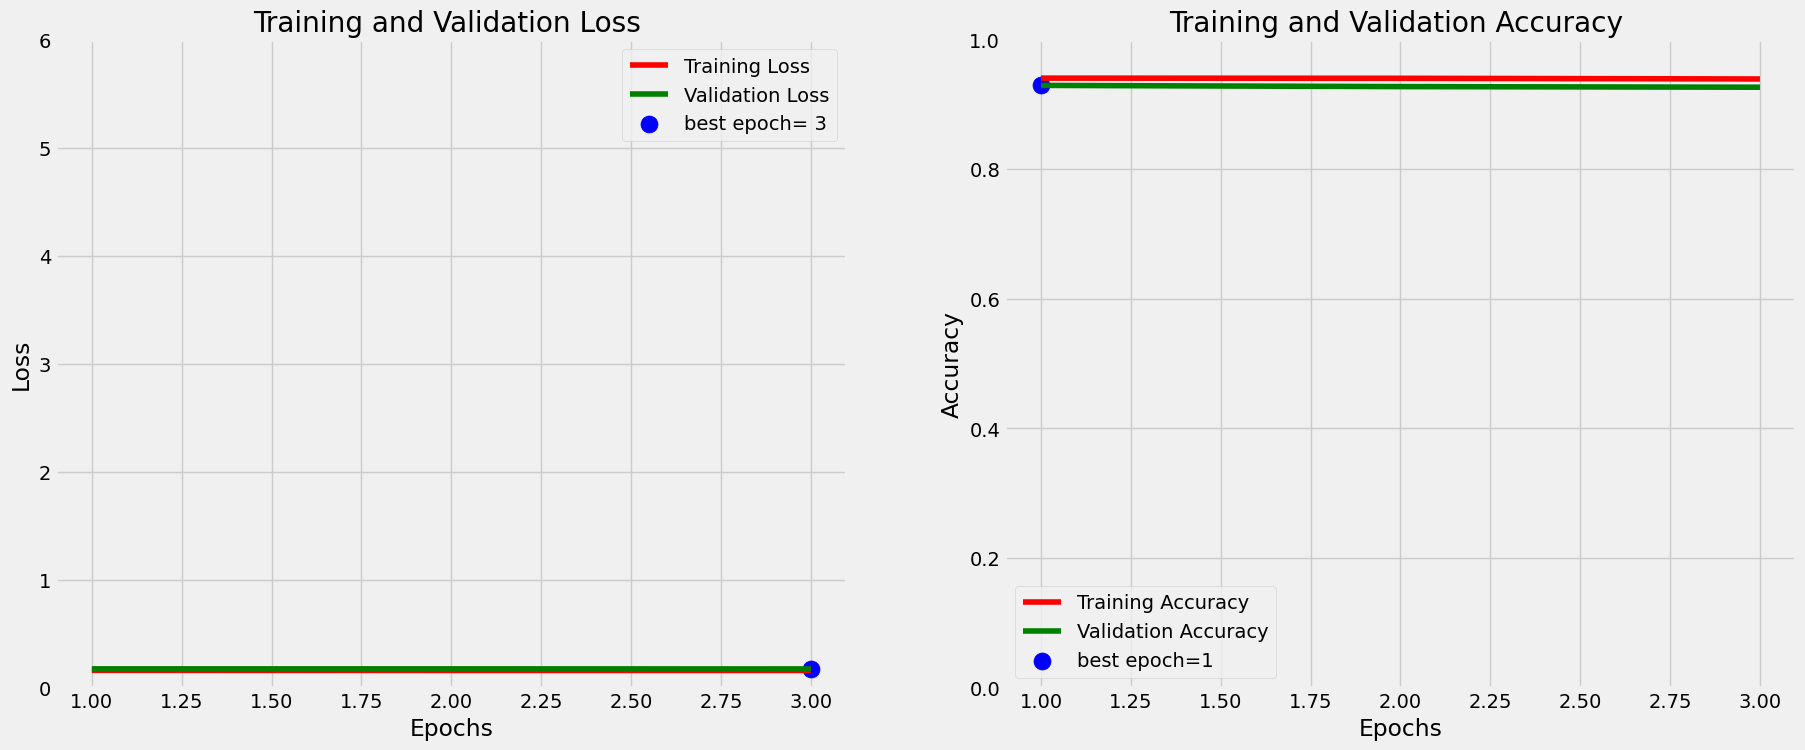

In [50]:
'''
#Desplay Model Performance



tr_acc = history.history["accuracy"]
tr_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest =val_acc[index_acc]
Epochs = [i+1 for i in range (len(tr_acc))]
loss_label = f"best epoch= {str(index_loss+1)}"
acc_label = f"best epoch={str(index_acc+1)}"

plt.figure(figsize =(20,8))
plt.style.use("fivethirtyeight")

plt.subplot(1,2,1)
plt.plot(Epochs ,tr_loss ,'r',label = "Training Loss")
plt.plot(Epochs , val_loss ,'g',label="Validation Loss")
plt.scatter(index_loss+1 ,val_lowest , s=150 ,c= "blue",label = loss_label)
plt.title("Training and Validation Loss ")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0,6)
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs ,tr_acc ,'r',label = "Training Accuracy")
plt.plot(Epochs , val_acc ,'g',label="Validation Accuracy")
plt.scatter(index_acc+1 ,acc_highest , s=150 ,c= "blue",label = acc_label)
plt.title("Training and Validation Accuracy ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend()

plt.tight_layout
plt.show()               '''

In [34]:
'''
#Evaluate Model


ts_length= len(test_df)
test_batch_size =max(sorted([ts_length//n for n in range (1, ts_length +1)if ts_length%n == 0 and ts_length/n <=80]))
test_steps =ts_length // test_batch_size

train_score =model.evaluate(train_gen ,steps= test_steps , verbose =1 )
valid_score =model.evaluate(valid_gen ,steps= test_steps , verbose =1 )
test_score =model.evaluate(test_gen ,steps= test_steps , verbose =1 )

print("Train Loss:" , train_score[0])
print("Traing Accuracy :",train_score[1])
print("-"*20)

print("Valid Loss:" , valid_score[0])
print("Valid Accuracy :", valid_score[1])
print("-"*20)

print("Test Loss:" , test_score[0])
print("Test Accuracy :",test_score[1])

'''

17/18 [===========================>..] - ETA: 2s - loss: 0.1762 - accuracy: 0.9274

17/18 [===========================>..] - ETA: 2s - loss: 0.1846 - accuracy: 0.9171

18/18 [==============================] - 50s 3s/step - loss: 0.1846 - accuracy: 0.9171
Train Loss: 0.13874930143356323
Traing Accuracy : 0.9505208134651184
--------------------
Valid Loss: 0.17619429528713226
Valid Accuracy : 0.9274269342422485
--------------------
Test Loss: 0.18458697199821472
Test Accuracy : 0.9171375036239624


In [10]:
#Get Predictions

preds=model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis=1 )


<ipython-input-10-33b299c8ac19>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds=model.predict_generator(test_gen)


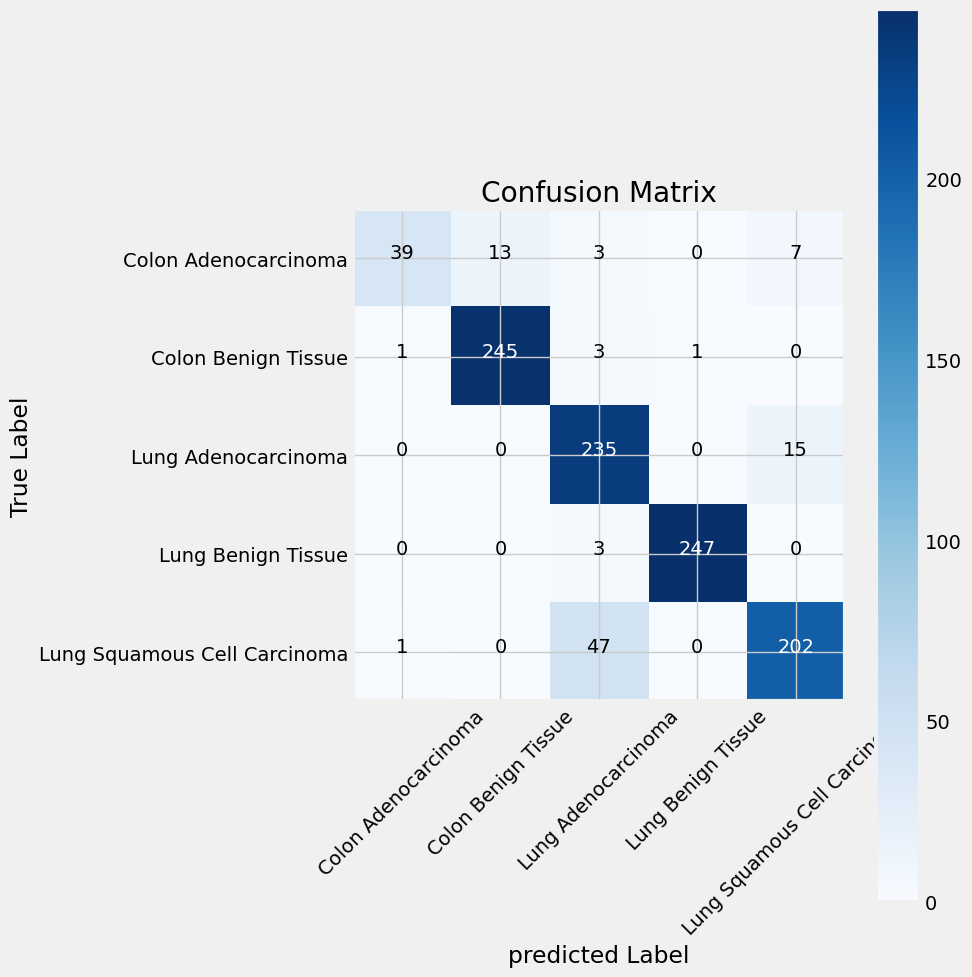

In [51]:

#Confusion Matrics and Classification Report


'''
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm,interpolation="nearest",cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks =np.arange(len(classes))
plt.xticks(tick_marks, classes ,rotation =45)
plt.yticks(tick_marks ,classes)

thresh =cm.max()/2
for i ,j in itertools.product (range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],horizontalalignment = "center",color = "white" if cm[i,j]>thresh else "black")

    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("predicted Label")

    plt.show   '''

In [52]:
#print(classification_report(test_gen.classes ,y_pred , target_names=classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.95      0.63      0.76        62
         Colon Benign Tissue       0.95      0.98      0.96       250
         Lung Adenocarcinoma       0.81      0.94      0.87       250
          Lung Benign Tissue       1.00      0.99      0.99       250
Lung Squamous Cell Carcinoma       0.90      0.81      0.85       250

                    accuracy                           0.91      1062
                   macro avg       0.92      0.87      0.89      1062
                weighted avg       0.92      0.91      0.91      1062



In [12]:
model= tf.keras.models.load_model(r"/content/drive/MyDrive/fullcode/ffullseq.h5",

                                           compile=False)
model.compile(Adamax(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
def predict_with_model(image_path, model, classes):
    # Load the image
    try:
        image = Image.open(image_path)
        image_rgb = image.convert("RGB")
    except Exception as e:
        print("Error:", e)
        return

    # Check if the image is in RGB format
    if image_rgb.mode != "RGB":
        print("The uploaded image does not appear to be in the RGB format.")
        return

    # Resize the image
    img = image_rgb.resize((224, 224))

    # Convert the image to array and expand dimensions
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = classes[predicted_class_index]
    confidence_percentage = predictions[0][predicted_class_index] * 100

    # Print the prediction results
    print(f"Predicted Class: {predicted_class_label}")
    print(f"Confidence: {confidence_percentage:.2f}%")

    # Check if the predicted class is related to lung or colon cancer
    lung_classes = ["Lung Adenocarcinoma", "Lung Benign Tissue", "Lung Squamous Cell Carcinoma"]
    colon_classes = ["Colon Adenocarcinoma", "Colon Benign Tissue"]

    if predicted_class_label in lung_classes:
        print("The uploaded image is related to lung cancer.")
    elif predicted_class_label in colon_classes:
        print("The uploaded image is related to colon cancer.")
    else:
        print("The uploaded image does not appear to be a histopathological image of lung or colon cancer.")


In [14]:
image_path = r"/content/drive/MyDrive/Colab Notebooks/Lung and Colon cancer /lc25k/lung_colon_image_set/colon_image_sets/colon_aca/colonca4949.jpeg"
predict_with_model(image_path, model, classes)

1/1 [==============================] - 1s 983ms/step
Predicted Class: Colon Adenocarcinoma
Confidence: 97.20%
The uploaded image is related to colon cancer.


#**Gradio**

In [15]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import io

# Load the pre-trained model and classes
loaded_model3 = tf.keras.models.load_model("/content/drive/MyDrive/fullcode/ffullseq.h5", compile=False)
loaded_model3.compile(tf.keras.optimizers.Adamax(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Define the predict_with_model function
def predict_with_model(image):
    # Convert the image data to bytes
    image_bytes = io.BytesIO()
    image.save(image_bytes, format='PNG')
    image_bytes.seek(0)

    # Load the image from bytes
    try:
        image = Image.open(image_bytes)
    except Exception as e:
        return "Error: " + str(e)

    # Preprocess the image
    image_rgb = image.convert("RGB")  # Ensure image is in RGB format
    img = image_rgb.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Predict the class
    predictions =loaded_model3.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = classes[predicted_class_index]
    confidence_percentage = predictions[0][predicted_class_index] * 100

    # Check if the predicted class is related to lung or colon cancer
    lung_classes = ["Lung Adenocarcinoma", "Lung Benign Tissue", "Lung Squamous Cell Carcinoma"]
    colon_classes = ["Colon Adenocarcinoma", "Colon Benign Tissue"]

    if predicted_class_label in lung_classes:
        cancer_type = "Lung Cancer"
    elif predicted_class_label in colon_classes:
        cancer_type = "Colon Cancer"
    else:
        cancer_type = "Other"

    return f"Predicted Class: {predicted_class_label}, Confidence: {confidence_percentage:.2f}%, Cancer Type: {cancer_type}"

# Create the Gradio interface
image_input = gr.Image(label="Upload Image", type="pil")
output_text = gr.Textbox(label="Prediction")

gr.Interface(fn=predict_with_model, inputs=image_input, outputs=output_text, title="Histopathological Image Classifier").launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://73ff2ea711f46db093.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
